In [50]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import time
from torch.distributions import Beta
from torch.utils.data.sampler import BatchSampler, SubsetRandomSampler
from collections import deque



### Definition of net work

In [51]:
class Net(nn.Module):
    def __init__(self, image_stack):
        super(Net, self).__init__()
        # input shape is (4, 96, 96)
        self.cnn_base = nn.Sequential(
            nn.Conv2d(image_stack, 8, kernel_size=4, stride=2),
            nn.ReLU(), # (8, 47, 47)
            nn.Conv2d(8, 16, kernel_size=3, stride=2),
            nn.ReLU(), # (16, 23, 23)
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.ReLU(), # (32, 11, 11)
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
            nn.ReLU(), # (64, 5, 5)
            nn.Conv2d(64, 128, kernel_size=3, stride=1),
            nn.ReLU(), # (128, 3, 3)
            nn.Conv2d(128, 256, kernel_size=3, stride=1),
            nn.ReLU(), # (256, 1, 1)
        ) # output shape is (256, 1, 1)
        self.v = nn.Sequential(
            nn.Linear(256, 100),
            nn.ReLU(),
            nn.Linear(100, 1)
        )
        self.fc = nn.Sequential(
            nn.Linear(256, 100),
            nn.ReLU(),
        )
        self.alpha_head = nn.Sequential(
            nn.Linear(100, 3),
            nn.Softplus()
        )
        self.beta_head = nn.Sequential(
            nn.Linear(100, 3),
            nn.Softplus()
        )

        self.apply(self._weight_init)

    
    @staticmethod
    def _weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.constant_(m.bias, 0.1)

    def forward(self, x):
        # x is of shape (image_stack, 96, 96)
        x = self.cnn_base(x)
        x = x.view(-1, 256)
        v = self.v(x)
        x = self.fc(x)
        alpha = self.alpha_head(x)
        beta = self.beta_head(x)
        return (alpha, beta), v

### Definition of Agent

In [52]:
img_stack = 4

transition = np.dtype(
    [
        ('s', np.float64, (img_stack, 96, 96)),  # current state
        ('a', np.float64, (3,)),                 # action
        ('a_logp', np.float64),                  # action log probability
        ('r', np.float64),                       # reward
        ('s_', np.float64, (img_stack, 96, 96))  # next state
    ])


GAMMA = 0.99
EPOCH = 8
MAX_SIZE = 2000
BATCH = 128
EPS = 0.1
LEARNING_RATE = 0.001

class Agent:

    def __init__(self, device):
        self.training_step = 0
        self.net = Net(img_stack).to(device)
        self.buffer = np.empty(MAX_SIZE, dtype=transition)
        self.counter = 0
        self.device = device

        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=LEARNING_RATE)

    def select_action(self, state):
        # the input state is of shape (4, 96, 96)
        # input state is a numpy array
        
        # unsqueeze add an additional dimension to index 0  (4, 96, 96) -> (1, 4, 96, 96)
        state = torch.from_numpy(state).float().to(self.device).unsqueeze(0)

        with torch.no_grad():
            (alpha, beta), _ = self.net(state)
        
        dist = Beta(alpha, beta)
        action = dist.sample()                      # shape is (1, 4)
        a_logp = dist.log_prob(action).sum(dim=1)   # shape is (1,)


        action = action.squeeze().cpu().numpy()     # squeeze will remove dimensions of size 1, hence shape is (4,)
        a_logp = a_logp.item()
        return action, a_logp
    
    def store(self, transition):
        self.buffer[self.counter] = transition
        self.counter += 1
        if self.counter == MAX_SIZE:
            self.counter = 0
            return True
        return False
    
    def update(self):
        self.training_step += 1

        s = torch.tensor(self.buffer['s'], dtype=torch.float).to(self.device)
        a = torch.tensor(self.buffer['a'], dtype=torch.float).to(self.device)
        r = torch.tensor(self.buffer['r'], dtype=torch.float).to(self.device).view(-1, 1) # convert 1d tensor to 2d tensor with single column
        next_s = torch.tensor(self.buffer['s_'], dtype=torch.float).to(self.device)

        old_a_logp = torch.tensor(self.buffer['a_logp'], dtype=torch.float).to(self.device).view(-1, 1)

        with torch.no_grad():
            target_v = r + GAMMA * self.net(next_s)[1]
            adv = target_v - self.net(s)[1]     # advantage function
        
        for _ in range(EPOCH):
            for index in BatchSampler(SubsetRandomSampler(range(MAX_SIZE)), BATCH, False):
                (alpha, beta), _ = self.net(s[index])
                dist = Beta(alpha, beta)
                a_logp = dist.log_prob(a[index]).sum(dim=1, keepdim=True)
                ratio = (a_logp - old_a_logp[index]).exp()

                surr1 = ratio * adv[index]

                surr2 = torch.clamp(ratio, 1.0 - EPS, 1.0 + EPS) * adv[index]
                action_loss = -torch.min(surr1, surr2).mean()
                value_loss = F.smooth_l1_loss(self.net(s[index])[1], target_v[index])
                loss = action_loss + 2. * value_loss

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()



### Environment

In [53]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

# set up the environment
action_repeat = 10
env = gym.make('CarRacing-v2')
state = env.reset()
print("action space shape: ", env.action_space.shape)
reward_threshold = env.spec.reward_threshold
print("reward threshold: ", reward_threshold)

cuda
action space shape:  (3,)
reward threshold:  900


#### Image Preprocessing

preprocess the image

frame shape:  (96, 96, 3)
img.shape:  (96, 96)


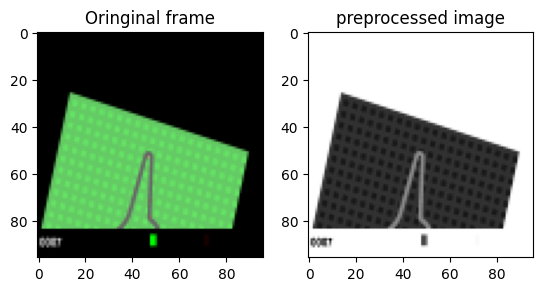

In [54]:
frame, reward, terminated, truncated, info = env.step(np.array([2., 1., 1.]))  # observation, reward, terminated, truncated, info

print("frame shape: ", frame.shape)
plt.subplot(1, 2, 1)
plt.imshow(frame)
plt.title("Oringinal frame")

# ------------------- #

def rgb2gray(rgb, norm=True):
        # rgb image -> gray [0, 1]
    gray = np.dot(rgb[..., :], [0.299, 0.587, 0.114])
    if norm:
        # normalize
        gray = gray / 128. - 1.
    return gray

# ------------------- #

img_gray = rgb2gray(frame)


plt.subplot(1,2,2)
plt.title('preprocessed image')

print('img.shape: ', img_gray.shape)

# 96 x 96 black and white image
plt.imshow(img_gray, cmap='Greys')
plt.show()

#### Class Wrapper

This is an environment wrapper for CarRacing

In [55]:

class Wrapper():


    def __init__(self, env):
        self.env = env
    

    def reset(self):
        self.counter = 0
        self.av_r = self.reward_memory()

        self.die = False
        img_rgb = env.reset()[0]
        img_gray = rgb2gray(img_rgb)
        self.stack = [img_gray] * img_stack
        return np.array(self.stack)
    
    def step(self, action):
        total_reward = 0
        for i in range(action_repeat):
            img_rgb, reward, terminated, truncated, info = env.step(action)
            die = terminated or truncated
            if die:
                reward += 100

            if np.mean(img_rgb[:, :, 1]) > 185.0:
                reward -= 0.05
            total_reward += reward

            # if no reward recently, end the episode
            done = True if self.av_r(reward) <= -0.1 else False

            if done or die:
                break
        
        img_gray = rgb2gray(img_rgb)
        self.stack.pop(0)
        self.stack.append(img_gray)
        assert len(self.stack) == img_stack
        return np.array(self.stack), total_reward, done, die

    
    @staticmethod
    def reward_memory():
        # record the reward for the last 100 steps
        count = 0
        length = 100
        history = np.zeros(length)

        def memory(reward):
            nonlocal count
            count = (count + 1) % length
            history[count] = reward
            return np.mean(history)
    
        return memory

In [56]:
def save(agent, directory, filename, suffix):
    torch.save(agent.net.state_dict(), '{}/{}_{}.pth'.format(directory, filename, suffix))

### Train Agent

In [57]:
# agent = Agent(device)
# env_wrapper = Wrapper(env)

# state = env_wrapper.reset()
# print("state shape: ", state.shape)

# action, a_logp = agent.select_action(state)
# print(action)

# env_wrapper.step(np.array(action).astype(np.float64))


In [58]:
agent = Agent(device)

env_wrapper = Wrapper(env)

limits = [200, 400, 600, 800, 830, 870, 900]

def return_suffix(j):
    suf = '0'
    for i in range(len(limits) - 1):
        if j >= limits[i] and j < limits[i + 1]:
            suf = str(i + 1)
            break

        i_last = len(limits) - 1
        if j >= limits[i_last]:
            suf = str(i_last + 1)
            break
    return suf


def ppo_train(n_episodes = 5000, save_every = 500):

    scores_deque = deque(maxlen=100)
    scores_array = []
    avg_scores_array = []

    timestep_after_last_save = 0

    time_start = time.time()

    running_score = 0
    state = env_wrapper.reset()

    i_lim = 0
    for i_episode in range(n_episodes):

        timestep = 0
        total_reward = 0

        state = env_wrapper.reset()

        while True:

            action, a_logp = agent.select_action(state)
            next_state, reward, done, die = env_wrapper.step(np.array(action).astype(np.float64))

            if agent.store((state, action, a_logp, reward, next_state)):
                print('updating')
                agent.update()
            
            total_reward += reward
            state = next_state
            timestep += 1
            timestep_after_last_save += 1

            if done or die:
                break
        
        running_score  = running_score * 0.99 + total_reward * 0.01

        scores_deque.append(total_reward)
        scores_array.append(total_reward)

        avg_score = np.mean(scores_deque)
        avg_scores_array.append(avg_score)

        s = (int)(time.time() - time_start)
        print('Ep. {}, Ep.Timesteps {}, Score: {:.2f}, Avg.Score: {:.2f}, Run.Score {:.2f}, \
Time: {:02}:{:02}:{:02} '\
            .format(i_episode, timestep, \
                    total_reward, avg_score, running_score, s//3600, s%3600//60, s%60))  


        # Save episode if more than save_every=500 timesteps
        if timestep_after_last_save >= save_every:

            timestep_after_last_save %= save_every            
            suf = return_suffix(avg_score)
            save(agent, 'dir_chk', 'model_weights', suf)
            
        if np.mean(scores_deque) > reward_threshold:
            print("Solved environment! Running score is {:.2f}, Avg.Score: {:.2f} !" \
                  .format(running_score, avg_score))
            break

    return scores_array, avg_scores_array    
            
scores, avg_scores  = ppo_train()   


Ep. 0, Ep.Timesteps 66, Score: -17.95, Avg.Score: -17.95, Run.Score -0.18, Time: 00:00:12 
Ep. 1, Ep.Timesteps 51, Score: -18.05, Avg.Score: -18.00, Run.Score -0.36, Time: 00:00:22 
Ep. 2, Ep.Timesteps 55, Score: -17.97, Avg.Score: -17.99, Run.Score -0.53, Time: 00:00:30 
Ep. 3, Ep.Timesteps 44, Score: -18.00, Avg.Score: -17.99, Run.Score -0.71, Time: 00:00:37 
Ep. 4, Ep.Timesteps 54, Score: -18.06, Avg.Score: -18.01, Run.Score -0.88, Time: 00:00:45 
Ep. 5, Ep.Timesteps 42, Score: -18.02, Avg.Score: -18.01, Run.Score -1.05, Time: 00:00:51 
Ep. 6, Ep.Timesteps 44, Score: -18.07, Avg.Score: -18.02, Run.Score -1.22, Time: 00:00:58 
Ep. 7, Ep.Timesteps 48, Score: -18.07, Avg.Score: -18.02, Run.Score -1.39, Time: 00:01:05 
Ep. 8, Ep.Timesteps 49, Score: -18.07, Avg.Score: -18.03, Run.Score -1.56, Time: 00:01:12 
Ep. 9, Ep.Timesteps 45, Score: -18.03, Avg.Score: -18.03, Run.Score -1.72, Time: 00:01:19 
Ep. 10, Ep.Timesteps 55, Score: -17.91, Avg.Score: -18.02, Run.Score -1.89, Time: 00:01:26

KeyboardInterrupt: 